In [8]:
'''
Code to read NIFTI files

'''

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from mpl_toolkits import mplot3d #for 3d plots

from copy import copy, deepcopy  #to copy matrices
import numpy as np
import os
#import pydicom  --installed in colab bia pip
from PIL import Image #for RGB manipulation

import matplotlib.animation as animation #just for animating a plot

#generic toolset for transformations
import scipy.misc
from scipy import ndimage
import scipy.io as sio
from scipy import signal  #for convolution filtering
import cv2 as cv2         #for convolution filtering
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 
!pip3 install -q SimpleITK
!pip3 install -q medpy
!pip3 install nibabel          #NIFTI library support
!pip3 install -q celluloid     #animation extra library

import SimpleITK as sitk  #for reading mha files
from medpy.io import load #mha files
import pydicom #to read dicom files
import nibabel as nib         #pull in library
from celluloid import Camera  #for an alternative animation method
#
# Load data from google drive
#

drive.mount('/content/gdrive')

'''
REPLACE NAN DATA----------------------------------------------------------------
'''

def replace_nan(data, lowval=-1600):
    #a=np.isnan(data)
    #lowval = -1600
    new_data = data #only a slice should be sent in here
    new_data[np.isnan(new_data)]= lowval

    a = np.isnan(new_data)
    #print('sample value after nan replace (0,0) : ',new_data[0,0])
    sdata = new_data #new_data[215:220,145:155,140]
    row,col = np.shape(sdata)
    #print('nan replace shape is ', row,col)

    return sdata

'''
Celluloid animation package
'''
def cell_animate(image_dir, 
                 base_filename, 
                 stack,
                 slice_column =2,
                 cmapin='bone',
                 cbar = 1):
    fig = plt.figure()
    camera = Camera(fig)

    #fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize=(5, 5),squeeze=False)
    #camera = Camera(fig)

    dir_name = image_dir #"/home/kgonzalez/IMAGES"
    #base_filename = "figure"
    filename_suffix = ".png"
    x,y,num_frames = np.shape(stack) 

    vidfile = os.path.join(dir_name,'animatedct.gif');
    for ii in range(0,num_frames):
        
        plt.imshow(stack[:,:,ii],cmap=cmapin)
        plt.title('CT Skull Image')
        #if (cbar == 1):
        #    plt.colorbar()
        #im0 = axes[0].imshow(stack[:,:,ii],cmap=cmapin);
        #use fraction and pad to shrink colorbar to fit image
        #fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)
        #name = os.path.join(dir_name, base_filename + str(ii).zfill(5)  + filename_suffix)
        #print('name is: ',name)
        
        #plt.savefig(name) # save as png

        camera.snap()
    animation = camera.animate()
    animation.save(vidfile, writer = 'imagemagick')


    return 0

'''
ANIMATE IMAGES------------------------------------------------------------------
'''
def animate_image(image_dir, base_filename, stack):
    plt.close()
    plt.rcParams["animation.html"] = "jshtml"

    #plt.figure()
    #plt.imshow(stack[:,:,300])
    fig=plt.figure()
    #plt.imshow(stack[:,:,255])
    ims = []
    dir_name = image_dir #"/home/kgonzalez/IMAGES"
    #base_filename = "figure"
    filename_suffix = ".png"
    x,y,num_frames = np.shape(stack) 
    print('number of frames to animate is ',num_frames)
    for ii in range(0,num_frames):
        im = plt.imshow(stack[:,:,ii], animated=True)
        ims.append([im])
        plt.imshow(stack[:,:,ii],cmap='gray')
        plt.title('CT Skull Image')
        name = os.path.join(dir_name, base_filename + str(ii).zfill(5)  + filename_suffix)
        #print('name is: ',name)
        
        plt.savefig(name) # save as png
    print('done animating images')
    plt.show()
    ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
        repeat_delay=500)
    #plt.show()
    mp4name = os.path.join(dir_name, 'dyn.mp4')
    ani.save(mp4name)
    print('done with animation mp4')
    return 0




def read_NIFTI():
    print("test")


'''
FIND METAL COMPONENTS-----------------------------------------------------------
'''
def find_metal_mass(section, metal_value, depth):
    upper_val = 1.15 #110% of incoming value
    lower_val = 0.85
    row1,col1 = np.shape(section) #section.shape() #should be just one slice
    output_coordinates = set()

    #print('in find_metal_mass, row and col are ',row1, col1)
    for row in range(0,row1):
        for col in range(0,col1):
            #find a voxel that is surrounded on all 4 sides by the 
            #metal_value voxels depth wide
            pixel_x = col
            pixel_y = row

            if ((row - depth) >= 0):
                if ((col - depth) >= 0):
                    #if we're not on the boundaries, check to see if we have 
                    #voxel values around us within 10% of the metal_value

                    #if pixel - col depth : pixel + col depth AND
                    #if pixel - row depth: pixel + row depth are all within the
                    #range for metal, keep this pixel as a possible match

                    avg_cols = np.average(section[row,col-depth:col+depth])
                    avg_rows = np.average(section[row-depth:row+depth,col])
                    #print('row,col: avgc, avgr ', pixel_y, pixel_x,
                    #      avg_cols, avg_rows)
                    if ( (avg_cols >= (lower_val*metal_value) and (avg_cols <= (upper_val*metal_value))) \
                        and \
                        ((avg_rows >= (lower_val*metal_value)) and (avg_cols <= (upper_val*metal_value))) \
                        ):
                        #print('found one pixel')
                        output_coordinates.add((pixel_y, pixel_x))
                    #sum_value = np.sum(section[row-depth:row+depth,col-depth:col+depth])
                    #print('sum_value ',sum_value)
    return output_coordinates



def find_dbs_length(section, metal_value, depth,lower_val=0.7, upper_val=1.15):
    #upper_val = 1.15 #110% of incoming value
    #lower_val = 0.7
    row1,col1 = np.shape(section) #section.shape() #should be just one slice
    
    output_coordinates = set()

    #print('in find_metal_mass, row and col are ',row1, col1)
    for row in range(0,row1):
        for col in range(0,col1):
            #find a voxel that is diagonally or straight across

            pixel_x = col
            pixel_y = row
            #for each pixel, make sure we can't go out of bounds

            #if ((row - depth) >= 0):
            #    if ( (avg_cols >= (lower_val*metal_value) and (avg_cols <= (upper_val*metal_value))) \
            #        and \
            #        ((avg_rows >= (lower_val*metal_value)) and (avg_cols <= (upper_val*metal_value))) \
            #        ):
            #            #print('found one pixel')
            #        output_coordinates.add((pixel_y, pixel_x))
            #        #sum_value = np.sum(section[row-depth:row+depth,col-depth:col+depth])
            #        #print('sum_value ',sum_value)           

    return 0



'''
THRESHOLD METAL SPOTS
--Returns all pixels throughout a slice direction that is close to a metallic
return value
'''
def threshold_pixels3D(volume_data, #push in whole volume
                       metal_value, #typical metal value for this dataset
                       depth, 
                       lower_val=0.7, 
                       upper_val=1.15):

    x,y, numslices = np.shape(volume_data)

    

    return 0





def threshold_pixels2D():

    return 0





def plot_metal_points_2D(slice_data):
    plt.imshow(slice_data[:,:,ii],cmap='gray',vmin=-1600, vmax=3300)
    plt.xlabel('X vox')
    plt.ylabel('Y vox')
    tname = 'Slice #' + np.str(ii)

    plt.show()

    metal_xy = metal_points[ii]
    for ii in metal_xy:
        r = ii[0]
        c = ii[1]
        #print('row, col is ', r, c)
        circle1 = plt.Circle((c,r), 3,color='r', fill=False)
        #ax.set_aspect(1)
        ax.add_patch(circle1)
        #ax.add_artist(circle1)
        #plt.hold(True)
    plt.show()
    return 0


def apply_marker_to_metal(mloc_dict, stacked, cmapin='bone'):

    '''
    Take in data and put markers over dictionary areas indicating metal was found
    '''
    print('Plotting sequence with metal points')

    for current_slice_key in mloc_dict:
        print('current slice is',current_slice_key)
        fig,ax = plt.subplots()
        plt.imshow(stacked[:,:,current_slice_key],cmap=cmapin)

    for entry in mloc_dict[current_slice_key]:
        row = entry[0]
        col = entry[1]

        circle1 = plt.Circle((col,row), 3,color='r', fill=False)
        ax.add_patch(circle1)
    plt.colorbar()
    plt.title(current_slice_key)
    plt.show()

    return 0





'''
MAIN CODE SETUP-----------------------------------------------------------------
'''

gdir =           '/content/gdrive/My Drive/BIOENG223A_FALL_2019/data/'
main_directory = gdir

sub_dirs = sorted(os.listdir(main_directory))
print(sub_dirs)

file_dict={}  #hold all of the nii files
path_dict = {}

for ii in range(0,len(sub_dirs)):
    print(sub_dirs[ii])

    current_path = os.path.join(main_directory,sub_dirs[ii])
    file_list = os.listdir(current_path)
    print(file_list)

    extension = '.nii'
    counter = 0    #numbered listing of .nii files found
    for jj in range(len(file_list)):
        if file_list[jj].endswith('.nii'):
            print('found file: ',file_list[jj])


            file_dict[ii,counter]= file_list[jj]
            path_dict[ii,counter] = current_path
            counter = counter + 1


#now we have all the nii files in the folders





#    top_data_dir = '/content/gdrive/My Drive/RCC_DATA/clear_cell/' #data/jpg_train/'
#patient_directories = sorted(os.listdir(top_data_dir))
#clear_cell_dict ={}
#ct_type.append(os.listdir(os.path.join(top_data_dir,ii)))



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5']
subject_1
['Thumbs.db', 'fluoro_subject_1.jpg', 'hull_subject_1.nii', 'postopCT_subject_1.nii', 'preopCT_subject_1.nii', 'fluoro_subject_1.tif', 'linesMRI4.nii']
found file:  hull_subject_1.nii
found file:  postopCT_subject_1.nii
found file:  preopCT_subject_1.nii
found file:  linesMRI4.nii
subject_2
['fluoro_subject_2b.jpg', 'fluoro_subject_2.tif', 'fluoro_subject_2.jpg', 'fluoro_subject_2b.tif', 'preopCT_subject_2.nii', 'postopCT_subject_2.nii', 'hull_subject_2.nii']
found file:  preopCT_subject_2.nii
found file:  postopCT_subject_2.nii
found file:  hull_subject_2.nii
subject_3
['fluoro_subject_3.tif', 'fluoro_subject_3.jpg', 'hull_subject_3.nii', 'postopCT_subject_3.nii', 'preopCT_subject_3.nii']
found file:  hull_subject_3.nii
found file:  postopCT_subject_3.nii
found file:  preopCT_subje

In [9]:
'''
Kernels and other operators

'''

prewitt_x = [[-1, 0 ,1],[-1,0,1],[-1 ,0 ,1]]
prewitt_y = [[-1,-1,-1],[0,0,0], [1,1,1]]
print(np.matrix(prewitt_x))
print(np.matrix(prewitt_y))





[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]
[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


filename is  /content/gdrive/My Drive/BIOENG223A_FALL_2019/data/subject_5/preopCT_subject_5.nii


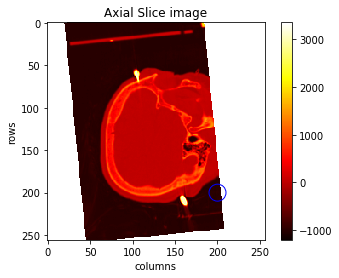

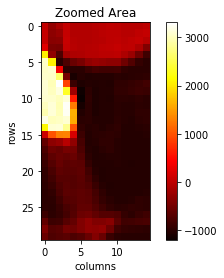

average is  -982.9591967773438
Metal Points Default Complete
Metal Points Orthogonal Complete


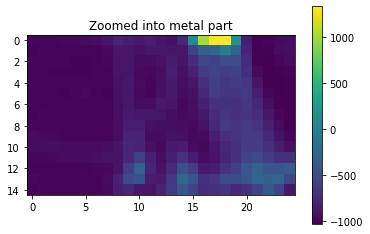

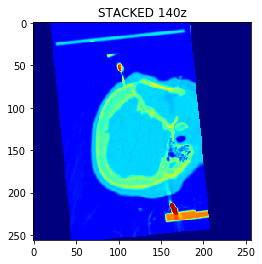

In [10]:
#DEBUG paths and filenames
for x in path_dict:
    #print(x,path_dict[x])
    continue
for x in file_dict:
    #print(x, file_dict[x])
    continue

### Load one of the files
f = os.path.join(path_dict[4,2],file_dict[4,2])
img = nib.load(f)
data = img.get_fdata()

# Show original image
print('filename is ',f)

fig, ax = plt.subplots()

snum = 134 #axial slicing


plt.imshow(data[:,:,snum],cmap='hot')
plt.xlabel('columns')
plt.ylabel('rows')
plt.title('Axial Slice image')
plt.colorbar()



circle1 = plt.Circle((200,200), 10,color='b', fill=False)
ax.set_aspect(1)
ax.add_artist(circle1)
plt.show()

#Zoomed area view
#

fig = plt.gcf()
ax = fig.gca()
plt.imshow(data[200:230,160:175,snum], cmap='hot')
plt.xlabel('columns')
plt.ylabel('rows')
plt.title('Zoomed Area')
plt.colorbar()
plt.show()


sum = np.sum(data[215:220,145:155,snum])
avg = np.average(data[215:220,145:155,140])
print('average is ', avg)


plt.figure()
plt.imshow(data[215:230,145:170,snum])
plt.colorbar()
plt.title('Zoomed into metal part')




# Detect metal mass over all AP slices and orthogonal
# Remove any NaN values before running over this data
#
sx,sy,sz = np.shape(data)
metal_points=[]
for ii in range(0,sz):
    #replace all NaN values with a default value
    new_data = replace_nan(data[:,:,ii], lowval=-1600)   
    #stacked =np.dstack(stacked,new_data)
    loc = find_metal_mass(section = new_data, metal_value = 3000, depth=4)
    metal_points.append(loc)
    if(ii ==0):
        stacked = new_data
    else:
        stacked = np.dstack([stacked,new_data])

print('Metal Points Default Complete')

plt.figure()
plt.imshow(stacked[:,:,140],cmap='jet')
plt.title('STACKED 140z')

'''
Get the metal points in the orthogonal direction now
'''


sx,sy,sz = np.shape(data)
metal_points90=[]
for ii in range(0,sy):
    #replace all NaN values with a default value
    new_data90 = replace_nan(data[:,ii,:], lowval=-1600)   
    #stacked =np.dstack(stacked,new_data)
    loc90 = find_metal_mass(section = new_data, metal_value = 3000, depth=4)
    metal_points90.append(loc)
    if(ii ==0):
        stacked90 = new_data90
    else:
        stacked90 = np.dstack([stacked90,new_data90])

print('Metal Points Orthogonal Complete')













In [6]:
'''
Get the metal points in the orthogonal direction now
'''


sx,sy,sz = np.shape(data)
metal_points90=[]
for ii in range(0,sy):
    #replace all NaN values with a default value
    new_data90 = replace_nan(data[:,ii,:], lowval=-1600)   
    #stacked =np.dstack(stacked,new_data)
    loc90 = find_metal_mass(section = new_data, metal_value = 3000, depth=4)
    metal_points90.append(loc)
    if(ii ==0):
        stacked90 = new_data90
    else:
        stacked90 = np.dstack([stacked90,new_data90])

print('Metal Points Orthogonal Complete')

Metal Points Orthogonal Complete


Metal Points ERD Complete
(176,)
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), {(234, 176), (228, 174), (229, 174), (231, 176), (230, 174)}, {(231, 174), (231, 175), (225, 172), (227, 173), (232, 176), (233, 175), (234, 176), (228, 174), (232, 175), (228, 173), (229, 174), (226, 173), (229, 175), (231, 176), (233, 176), (225, 171), (230, 175), (227, 174), (230, 174)}, {(224, 174), (229, 173), (224, 170), (226, 172), (225, 171), (227, 174), (230, 174), (231, 175), (225, 174), (232, 175), (228, 173), (224, 171), (223, 173), (226, 173), (225, 170), (230, 175), (231, 174), (227, 173), (225, 173), (228, 174), (224, 172), (223, 172), (226, 170), (229, 175), (226, 174), (223, 171), (227, 172), (225, 172), (224, 173), (226, 171), (229, 174), (223, 170)}, {(224, 174), (227, 171), (229, 173), (225, 175), (222, 171), (228, 172), (224, 170), (226, 172), (225, 171), (227, 174), (230, 174), (222, 172), (231, 175), (223, 169), (227, 170), (225, 174

IndexError: ignored

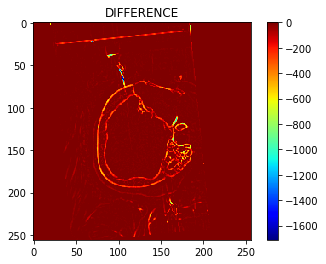

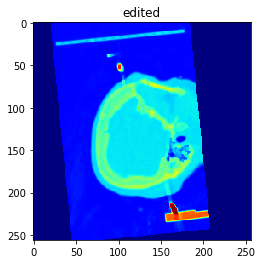

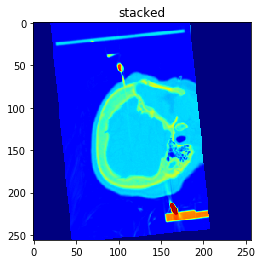

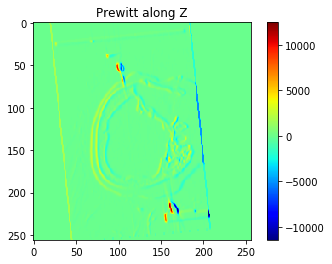

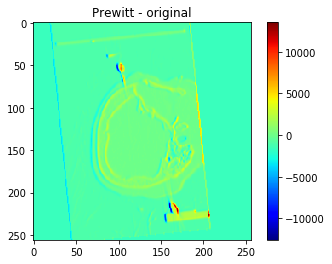

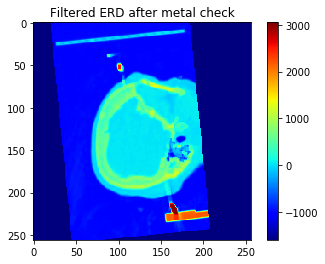

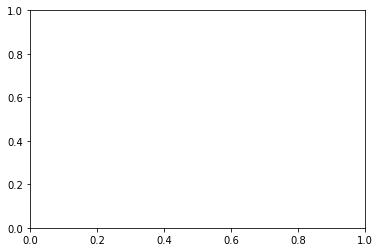

In [15]:
'''
--------------------------------------------------------------------------------
Apply a filter to the data before detecting metallic components
--------------------------------------------------------------------------------
'''

# Taking a matrix of size 5 as the kernel 
kernel = np.ones((3,3), np.float) 


# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
img_slice = stacked[:,:,144]
img_erosion = cv2.erode(img_slice, kernel, iterations=1) 
img_erode_dilate = cv2.dilate(img_erosion, kernel, iterations=1)
img_dilation = cv2.dilate(img_slice, kernel, iterations=1)


#
# Apply erosion and dilation
#
sx,sy,sz = np.shape(stacked)

pz = deepcopy(stacked)
erd_data = deepcopy(stacked)
for ii in range(0,sz):
    erd_data[:,:,ii] =cv2.erode(stacked[:,:,ii],kernel, iterations=1)
    pz[:,:,ii] = ndimage.prewitt(stacked[:,:,ii])
    erd_data[:,:,ii] = cv2.dilate(erd_data[:,:,ii],kernel,iterations=1)
#for ii in range(0,sy):
#    erd_data[:,ii,:] =cv2.dilate(stacked[:,ii,:],kernel, iterations=1)

#subtraction of original and opened image
diff_data = np.subtract(erd_data,stacked)
plt.figure()
plt.imshow(diff_data[:,:,140],cmap='jet')
plt.colorbar()
plt.title('DIFFERENCE')

plt.figure()
plt.imshow(erd_data[:,:,140],cmap='jet')
plt.title('edited')

plt.figure()
plt.imshow(stacked[:,:,140],cmap='jet')
plt.title('stacked')

plt.figure()
plt.imshow(pz[:,:,140],cmap='jet')
plt.colorbar()
plt.title('Prewitt along Z')

plt.figure()
diffp = np.subtract(stacked,pz)
plt.imshow(diffp[:,:,140],cmap='jet')
plt.colorbar()
plt.title('Prewitt - original')

#
# ERD METAL LOCATIONS
#

sx,sy,sz = np.shape(erd_data)
metal_points_erd=[]
mloc_dict={}
for ii in range(0,sz):
    #replace all NaN values with a default value
    new_data_erd = replace_nan(erd_data[:,:,ii], lowval=-1600)   
    #stacked =np.dstack(stacked,new_data)
    loc_erd = find_metal_mass(section = new_data_erd, metal_value = 3000, depth=4)
    metal_points_erd.append(loc_erd)
    if(ii ==0):
        stacked_erd = new_data_erd
    else:
        stacked_erd = np.dstack([stacked_erd,new_data_erd])

print('Metal Points ERD Complete')
print(np.shape(metal_points_erd))
print(metal_points_erd)











plt.figure()
plt.imshow(stacked_erd[:,:,140],cmap='jet')
plt.colorbar()
plt.title('Filtered ERD after metal check')



print('Applying metal markers to images')
apply_marker_to_metal(metal_points_erd, stacked_erd, cmapin='bone')


return

### Save eroded and dilated image to new nift, reuse old header
#another_img = nib.Nifti1Image(new_data, img.affine, empty_header)
erd_img = nib.Nifti1Image(erd_data, img.affine, img.header)
morph_file = os.path.join(path_dict[4,2],'morphed_file.nii')
print('morph file is ', morph_file)
nib.save(erd_img, morph_file) #'clipped_image.nii')

frame_dir = '/content/gdrive/My Drive/ANIMATION_FIGS'
print(frame_dir)
cell_animate(frame_dir, "diff", diff_data,cmapin='jet',cbar=1)


hist,bins=np.histogram(erd_data[:,:,140],50)
plt.hist(hist,bins)
print(np.shape(hist))
print(np.shape(bins))




return


#-------------------------------------------------------------------------------
#Side-by-side plots
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize=(15, 15))
im0 = axes[0].imshow(img_slice,cmap='jet');

im1 = axes[1].imshow(img_erosion[:,:],cmap='jet')
im2 = axes[2].imshow(img_dilation[:,:],cmap='jet')
im3 = axes[3].imshow(img_erode_dilate[:,:],cmap='jet')

#use fraction and pad to shrink colorbar to fit image
fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)
fig.colorbar(im1,ax = axes[1],fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[2],fraction=0.046, pad=0.04)
fig.colorbar(im3, ax = axes[3],fraction=0.046, pad=0.04)

axes[0].set_title("Original")
axes[1].set_title("Erosion")
axes[2].set_title("Dilation")
axes[3].set_title("Erosion + Dilation")
fig.tight_layout()



new_image = cv2.GaussianBlur(stacked[:,:,140], (15,15),0)

plt.figure()
plt.imshow(new_image)


#-------------------------------------------------------------------------------
#Side-by-side plots
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize=(15, 15))
im0 = axes[0].imshow(erd_data[100,:,:],cmap='jet');

im1 = axes[1].imshow(erd_data[:,:,144],cmap='jet')
im2 = axes[2].imshow(erd_data[:,100,:],cmap='jet')


#use fraction and pad to shrink colorbar to fit image
fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)
fig.colorbar(im1,ax = axes[1],fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[2],fraction=0.046, pad=0.04)


axes[0].set_title("ERD ROW 100")
axes[1].set_title("ERD Z   144")
axes[2].set_title("ERD COL 100")

fig.tight_layout()



In [0]:
sx = [[-1, 0 ,1],[-1 ,0,1],[-1 ,0 ,1]]
sy = [[-1,-1,-1],[0,0,0],[1,1,1]]
print(np.matrix(sx))
print(np.matrix(sy))

return

hist,bins=np.histogram(erd_data[:,:,140],15)
plt.hist(hist,bins)
plt.title('Histogram of Difference')
print(np.shape(hist))
print(np.shape(bins))
print(bins)
index1 = np.where(erd_data < 0)
index2 = np.where(erd_data >= 0)
print(np.shape(index))
temp = deepcopy(erd_data)
temp[index1[0][:],index1[1][:],index1[2][:]] = -5000
temp[index2[0][:],index2[1][:],index2[2][:]] = -4000
plt.figure()
plt.imshow(temp[:,:,140])
plt.colorbar()

sx = [[-1, 0 ,-1]]

[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]
[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


SyntaxError: ignored

In [0]:
'''
ADD MARKERS TO THE METALLIC POINTS FOUND EARLIER FOR REVIEW
'''
numslice=np.shape(metal_points)

print(numslice[0])
for ii in range(0,numslice[0]):
    fig, ax = plt.subplots()
    #plt.figure()
    plt.imshow(stacked[:,:,ii],cmap='gray',vmin=-1600, vmax=3300)
    plt.xlabel('X vox')
    plt.ylabel('Y vox')
    tname = 'Axial Slice #' + np.str(ii)
    plt.title(tname)
    plt.colorbar()
    #plt.show()

    metal_xy = metal_points[ii]
    for ii in metal_xy:
        r = ii[0]
        c = ii[1]
        #print('row, col is ', r, c)
        circle1 = plt.Circle((c,r), 3,color='r', fill=False)
        #ax.set_aspect(1)
        ax.add_patch(circle1)
        #ax.add_artist(circle1)
        #plt.hold(True)
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

(50,)
(51,)
[24417     0     0     0     2  3310 18889  1016   341   251   191   204
   216   201   248   735  8245  1719   381   368   500   741   669   601
   478   440   294   245   149    79    53    28    23    13    15    19
    32    54   204    40    21    18     6     9     2     6     9    36
    14     4]
[-1600.         -1501.88270508 -1403.76541016 -1305.64811523
 -1207.53082031 -1109.41352539 -1011.29623047  -913.17893555
  -815.06164062  -716.9443457   -618.82705078  -520.70975586
  -422.59246094  -324.47516602  -226.35787109  -128.24057617
   -30.12328125    67.99401367   166.11130859   264.22860352
   362.34589844   460.46319336   558.58048828   656.6977832
   754.81507813   852.93237305   951.04966797  1049.16696289
  1147.28425781  1245.40155273  1343.51884766  1441.63614258
  1539.7534375   1637.87073242  1735.98802734  1834.10532227
  1932.22261719  2030.33991211  2128.45720703  2226.57450195
  2324.69179687  2422.8090918   2520.92638672  2619.04368164
  2717.16097

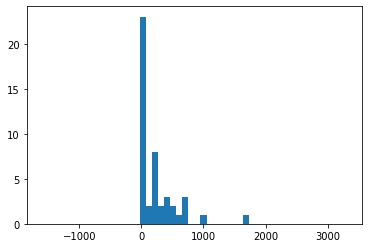

In [0]:
'''
HISTOGRAM INFORMATION
'''
hist,bins=np.histogram(stacked[:,:,140],50)
plt.hist(hist,bins)
print(np.shape(hist))
print(np.shape(bins))
print(hist)
print(bins)



In [0]:
for ii, enum in enumerate(hist):
    current_bin = enum 
    print(current_bin)

24417
0
0
0
2
3310
18889
1016
341
251
191
204
216
201
248
735
8245
1719
381
368
500
741
669
601
478
440
294
245
149
79
53
28
23
13
15
19
32
54
204
40
21
18
6
9
2
6
9
36
14
4


/content/gdrive/My Drive/BIOENG223A_FALL_2019/data/subject_5
<class 'dict'>
{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Feb  5 16:22:51 2018', '__version__': '1.0', '__globals__': [], 'mask_indices': array([[ -15.5514739 , -114.27784729,  -10.14976215],
       [ -13.55147417, -113.27784729,   -6.14976232],
       [ -14.55147417, -113.27784729,   -6.14976235],
       ...,
       [   1.44852476,   50.72215271,    9.85023729],
       [   3.44852483,   50.72215271,    8.85023742],
       [   2.44852483,   50.72215271,    8.85023738]])}


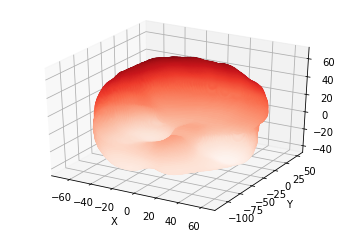

'\n !!!!!!!!!!  Check this out for plotting, Mayavi2\n '

In [0]:
'''
HULL FILE IMPORT AND VIEW

'''
print(current_path)
hull_file_name = 'hull.mat'

hull_file = os.path.join(current_path, hull_file_name)
hull_data = sio.loadmat(hull_file)
print(type(hull_data))
print(hull_data)
mdata =hull_data['mask_indices']
np.shape(mdata)
#mat = scipy.io.loadmat('file.mat')

%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = mdata[:,0]
ydata = mdata[:,1]
zdata = mdata[:,2]

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

'''
 !!!!!!!!!!  Check this out for plotting, Mayavi2
 '''

In [0]:
'''
Testing 3d metal extraction
'''


mloc_dict={}
print(np.shape(stacked))
volume_data = img
dimensions = np.shape(stacked) #stacked has already had nan removal done

metal_value = 3000 #contrast value for typical metal

cols = dimensions[0]
rows = dimensions[1]
slices = dimensions[2]

#store xy points that have metal

for slicenum in range(0,slices):
    #if slicenum not in mloc_dict.keys():
    #    mloc_dict[slicenum] = []

    for rownum in range(0,rows):
        for colnum in range(0,cols):
            pixel_value = stacked[rownum, colnum,slicenum]
            if (pixel_value >= metal_value):
                #print('Metal found in slice/x/y', slicenum, rownum, colnum)
                #mlocations.append([rownum, colnum, slicenum])
                
                if slicenum not in mloc_dict.keys(): #first time seeing this
                    mloc_dict[slicenum]=[]
                    mloc_dict[slicenum].append([rownum, colnum, slicenum])

                    print('new dict @key @pixel value @row,col',slicenum,pixel_value,rownum,colnum)
                else:
                    #mloc_dict[slicenum] = [mloc_dict[slicenum],[rownum, colnum, slicenum]]
                    mloc_dict[slicenum].append([rownum, colnum, slicenum])
                    #print('adding value to dict')
                    
key = mloc_dict.get('keys')
print('key is ',key)
print('length of dict',len(mloc_dict))
#[*mloc_dict] same as iterating through the dictionary to get key values



(256, 256, 176)
new dict @key @pixel value @row,col 9 3139.795654296875 233 175
new dict @key @pixel value @row,col 10 3060.454833984375 231 176
new dict @key @pixel value @row,col 11 3068.08349609375 230 175
new dict @key @pixel value @row,col 12 3077.0654296875 229 173
new dict @key @pixel value @row,col 13 3050.906982421875 228 172
new dict @key @pixel value @row,col 14 3038.480712890625 226 172
new dict @key @pixel value @row,col 15 3016.01025390625 224 171
new dict @key @pixel value @row,col 16 3028.23681640625 223 170
new dict @key @pixel value @row,col 17 3028.067626953125 221 171
new dict @key @pixel value @row,col 18 3065.9111328125 220 170
new dict @key @pixel value @row,col 19 3019.348876953125 219 168
new dict @key @pixel value @row,col 20 3080.698486328125 218 168
new dict @key @pixel value @row,col 21 3066.843994140625 217 167
new dict @key @pixel value @row,col 22 3024.906982421875 216 168
new dict @key @pixel value @row,col 23 3078.149169921875 216 166
new dict @key @pi

In [0]:
'''
ADD CIRCLE TO METALLIC SPOTS

'''
print(mloc_dict.keys())  #debug to check which slices

## Test out a point
print(len(mloc_dict[9]))
print(type(mloc_dict[9]))
print(mloc_dict[9])
mloc_dict[9][0]


for current_slice_key in mloc_dict:
    print('current slice is',current_slice_key)
    fig,ax = plt.subplots()
    plt.imshow(stacked[:,:,current_slice_key],cmap='bone')

    for entry in mloc_dict[current_slice_key]:
        #print('slice, entry', current_slice_key,entry)
        row = entry[0]
        col = entry[1]

        circle1 = plt.Circle((col,row), 3,color='r', fill=False)
        ax.add_patch(circle1)
    plt.colorbar()
    plt.title(current_slice_key)
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

/content/gdrive/My Drive/ANIMATION_FIGS


MovieWriter imagemagick unavailable. Trying to use pillow instead.


0

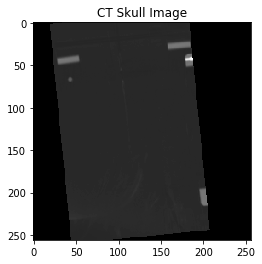

In [0]:
'''
ANIMATION OF A STACK OF SLICES
-- writes to the Google storage only
'''

frame_dir = '/content/gdrive/My Drive/ANIMATION_FIGS'
#frame_dir = '/home/kgonzalez/BE223A_2019/FRAMES'
print(frame_dir)
#plt.savefig('/home/kgonzalez/TEMP/test.png')
#animate_image(frame_dir, "figure", stacked)
cell_animate(frame_dir, "figure", stacked)

In [0]:
'''
Pull DBS locations
'''

for x in path_dict:
    #print(x,path_dict[x])
    continue
for x in file_dict:
    print(x, file_dict[x])
    continue
f = os.path.join(path_dict[4,2],file_dict[4,1])
post_img = nib.load(f)
post_data = post_img.get_fdata()

# Show original image
print('filename is ',f)


sx,sy,sz = np.shape(post_data)
metal_points=[]
for ii in range(0,sz):
    new_data = replace_nan(post_data[:,:,ii], lowval=-1600)   
    #stacked =np.dstack(stacked,new_data)
    loc = find_metal_mass(section = new_data, metal_value = 2800, depth=2)
    metal_points.append(loc)
    if(ii ==0):
        stacked_post = new_data
    else:
        stacked_post = np.dstack([stacked_post,new_data])

print('Metal Points Complete')


'''
Replace NAN
'''
#new_data = replace_nan(data[:,:,snum], lowval=-1600)


(0, 0) hull_subject_1.nii
(0, 1) postopCT_subject_1.nii
(0, 2) preopCT_subject_1.nii
(0, 3) linesMRI4.nii
(1, 0) preopCT_subject_2.nii
(1, 1) postopCT_subject_2.nii
(1, 2) hull_subject_2.nii
(2, 0) hull_subject_3.nii
(2, 1) postopCT_subject_3.nii
(2, 2) preopCT_subject_3.nii
(3, 0) postopCT_subject_4.nii
(3, 1) hull_subject_4.nii
(3, 2) preopCT_subject_4.nii
(4, 0) hull_subject_5.nii
(4, 1) postopCT_subject_5.nii
(4, 2) preopCT_subject_5.nii
filename is  /content/gdrive/My Drive/BIOENG223A_FALL_2019/data/subject_5/postopCT_subject_5.nii
Metal Points Complete


'\nReplace NAN\n'

In [0]:
'''
Show Post-Op stacked images after metal finding
'''
print(metal_points)

numslice=np.shape(metal_points)

print(numslice[0])
for ii in range(0,numslice[0]):
    fig, ax = plt.subplots()
    #plt.figure()
    plt.imshow(stacked_post[:,:,ii],cmap='gray',vmin=-1600, vmax=3300)
    plt.xlabel('X vox')
    plt.ylabel('Y vox')
    tname = 'Post-Op Axial Slice #' + np.str(ii)
    plt.title(tname)
    plt.colorbar()
    #plt.show()

    metal_xy = metal_points[ii]
    for ii in metal_xy:
        r = ii[0]
        c = ii[1]
        #print('row, col is ', r, c)
        circle1 = plt.Circle((c,r), 3,color='r', fill=False)
        #ax.set_aspect(1)
        ax.add_patch(circle1)
        #ax.add_artist(circle1)
        #plt.hold(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [0]:
'''
TRANSFORMATION INFO
'''
#cm = img.coordmap
#print(cm)

strans=img.get_sform()

t=[]
for ii in strans:
    print('transform row is',ii)
    t.append(ii)
print(type(strans))
xrow = strans[0]
yrow = strans[1];
zrow = strans[2];
hrow = strans[3];

tmatrix = [xrow,yrow,zrow,hrow]
print(np.shape(tmatrix))
print(np.shape(xrow))

for row in range(0,256):
    for col in range(0,256):
        vec = [row,col,1,1]
        xnew,ynew,znew,hnew=  np.matmul(tmatrix,vec)
        #print('row,col --> xn,yn,zn,hn', row, col, xnew,ynew,znew,hnew)

print(t[0])
x = t[0]


n1_header = img.header
print(n1_header)

AttributeError: ignored

[[ 0.00000000e+00 -9.41083431e-02  9.91141379e-01 -7.47260590e+01]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00  1.11722153e+02]
 [ 0.00000000e+00 -9.95561957e-01 -9.36903954e-02  1.35526917e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
('P', 'I', 'R')
caff is  [[ 9.91141379e-01  0.00000000e+00  9.41083431e-02 -9.87236865e+01]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.43277847e+02]
 [-9.36903954e-02  0.00000000e+00  9.95561957e-01 -1.18341383e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
New Affine Ordering:  ('R', 'A', 'S')
<class 'numpy.ndarray'>
row, col, slice =  256 256 176
sample value after nan replace (0,0) :  -1600.0
nan replace shape is  256 256
max, min value in slice is  3305.86474609375 -1600.0


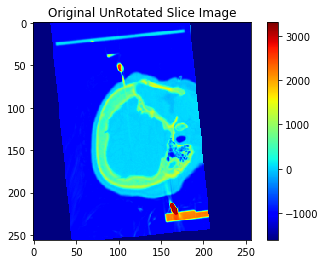

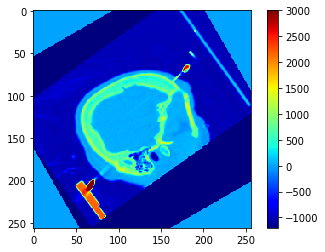

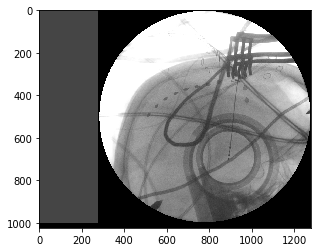

In [0]:
'''
Rotation of CT images to match the Flouro images
'''
#pick a slice, 140 for postOp 5 works well
#f = os.path.join(path_dict[0,0],file_dict[0,1])
ct_img = img #nib.load(f)
data_ct = ct_img.get_fdata()

af=img.affine
print(af)
affax=nib.aff2axcodes(img.affine)
print(affax)
#PIR is Ant to Post, Superior to inferior, Left to Right
canonical_img = nib.as_closest_canonical(img)
caff = canonical_img.affine
print('caff is ',caff)

new_affax=nib.aff2axcodes(canonical_img.affine)
print('New Affine Ordering: ',new_affax)
print(type(caff))
xs = []
ys = []
val = []


for row in range(0,256):
    for col in range(0,256):
        xyz = np.array([[row, col ,1, 1]])
        #print('shape xyz ',np.shape(xyz))
        xyzT=xyz.transpose()
        #print('shape xyz'' ',np.shape(xyzT))
        #print('shape caff is ',np.shape(caff))
     
        newx,newy,newz,H = np.dot(caff,xyzT) #matrix(caff,xyzT)
        xs.append(newx)
        ys.append(newy)

sdata = data_ct[:,:,140]







# Show original image
#print('filename is ',f)

#dir(img)

r,c,z=data_ct.shape
print('row, col, slice = ',r,c,z)
#choose slice number here
snum = 140 #slice number

data_ct_nonan =replace_nan(data_ct[:,:,snum], lowval=-1600)

maxc = np.max(data_ct_nonan[:,:])
minc = np.min(data_ct_nonan[:,:])


print('max, min value in slice is ', maxc, minc)
plt.imshow(data_ct_nonan[:,:],cmap='jet',vmin=-1600, vmax = 3300)
plt.title('Original UnRotated Slice Image')
plt.colorbar()

#rotate image with scipy, don't alter rotated image 
rot_angle = -60 #degrees CCW
rot_img = ndimage.rotate(data_ct[:,:,snum],-60, reshape=False)
plt.figure()
plt.imshow(rot_img,cmap = 'jet',vmin=-1200, vmax = 3000)
plt.colorbar()

f = os.path.join(path_dict[4,2],'fluoro_subject_5.tif')
tiff_file = f
I = plt.imread(tiff_file)
plt.figure()
plt.imshow(I)

In [0]:
a = np.zeros((5,5))
for row in a:

    print('row is ',row)

row is  [0. 0. 0. 0. 0.]
row is  [0. 0. 0. 0. 0.]
row is  [0. 0. 0. 0. 0.]
row is  [0. 0. 0. 0. 0.]
row is  [0. 0. 0. 0. 0.]


In [0]:
metal_value = 3000

print(data.shape)
slice = data[:,:,140]
print("values > metal are ",slice[slice> metal_value])
print("indices to high vals are ",np.nonzero(slice> metal_value))
index = np.nonzero(slice > metal_value)

#
print('length of index is ', len(index))


np.shape(index)
slice[index[0][:],0]
np.isnan(slice[index[0][:]],0)
#plt.imshow(slice[index[0],index[1]])

(256, 256, 176)
values > metal are  [3063.30297852 3118.78833008 3101.57250977 3070.55859375 3144.68457031
 3300.171875   3249.72436523 3227.05981445 3093.0234375  3254.51342773
 3252.26635742 3060.7578125  3255.10107422 3072.50170898 3076.65625
 3047.1003418  3067.92358398 3066.44262695 3049.85888672 3042.45874023
 3109.14331055 3053.97338867 3069.30932617 3078.04248047 3139.12817383
 3033.53564453 3104.95483398 3264.76367188 3084.08618164 3049.13305664
 3088.57324219 3022.17504883 3195.13696289 3112.99047852 3050.89550781
 3086.72167969 3035.65063477 3225.00097656 3001.19458008 3129.42114258
 3266.79467773 3189.83300781 3009.38525391 3125.56591797 3372.46508789
 3160.90600586 3072.53540039 3341.02148438 3248.23022461 3026.5456543
 3017.19458008 3251.84960938 3192.50805664 3094.58764648]
indices to high vals are  (array([ 56,  57,  58,  59,  59,  60,  61,  62,  62,  63,  63,  64,  64,
       213, 213, 213, 214, 214, 214, 214, 215, 215, 215, 215, 216, 216,
       216, 216, 217, 217, 21

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


TypeError: ignored

In [0]:
'''
Get the slices for the dataset that have metallic signatures (highest values)
'''

a=np.isnan(data)
lowval = -1600
new_data = data
new_data[np.isnan(new_data)]=-1600

plt.imshow(new_data[:,:,130],cmap = 'bone')
plt.colorbar()

slice = new_data[:,:,130]

print("values > metal are ",slice[slice> metal_value])
print("indices to high vals are ",np.nonzero(slice> metal_value))

metal_slices = []
num_slices = np.shape(data)[2]
for ii in range(0,num_slices):
    slice = new_data[:,:,ii]
    #print("slice number ",ii)
    values = slice[slice> metal_value]
    
    if (len(values) > 0):
        #print("values > metal are ",slice[slice> metal_value])
        #print("indices to high vals are ",np.nonzero(slice> metal_value))
        plt.figure()
        plt.imshow(slice[:,:], cmap='hot')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(ii)
        plt.colorbar()
        metal_slices.append(ii) #add this slice number to the metal list
        
    else:
        #print('length of values is ', len(values))
        continue


NameError: ignored

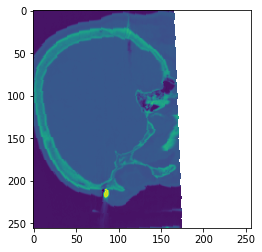

In [0]:
import time
from IPython import display

dsize = data.shape
degree = 5
for xx in range(40,50): #dsize[2]):
    #fig = plt.figure()
    plt.clf()
    #plt.imshow(data[:,:,xx],cmap='bone')
    #plt.colorbar()
    #plt.show()


    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    #time.sleep(0.1)
    tr = transforms.Affine2D().rotate_deg(degree)
    plt.imshow(data[:,:,xx],transform = tr)
    #ax.imshow(img, transform=tr)
    #fig.canvas.draw()
#plt.imshow(data[:,:,150])
#plt.colorbar()






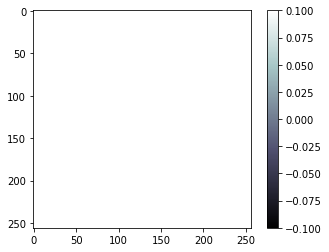

In [0]:
img = data[:,:,120]
rotated_img = ndimage.rotate(img,0.0)
plt.imshow(rotated_img,cmap='bone')
plt.colorbar()
plt.axis('on')
plt.show()

#img2 = scipy.misc.lena()

In [0]:
help(img)

Help on Nifti1Image in module nibabel.nifti1 object:

class Nifti1Image(Nifti1Pair)
 |  Class for single file NIfTI1 format image
 |  
 |  Method resolution order:
 |      Nifti1Image
 |      Nifti1Pair
 |      nibabel.analyze.AnalyzeImage
 |      nibabel.spatialimages.SpatialImage
 |      nibabel.dataobj_images.DataobjImage
 |      nibabel.filebasedimages.FileBasedImage
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  update_header(self)
 |      Harmonize header with image data and affine
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  files_types = (('image', '.nii'),)
 |  
 |  header_class = <class 'nibabel.nifti1.Nifti1Header'>
 |      Class for NIfTI1 header
 |      
 |      The NIfTI1 header has many more coded fields than the simpler Analyze
 |      variants.  NIfTI1 headers also have extensions.
 |      
 |      Nifti allows the header to be a separate file, as part of a nifti im